In [62]:
%matplotlib inline

First we load the ADHD200 data
-------------------------------



In [1]:
import numpy as np
#X=np.load('D:/Data/NYU/TC/ADHDTC12.npy')
tk='EMOTION'
#X=np.load('D:/Data/NeuroIMAGE.npy')
#X=np.load('D:/Data/NeuroIMAGE.npy')
X=np.load('D:/Data/NYU/NYUADHD118.npy')
from sklearn import preprocessing
#X=y
#X=np.load('D:/HCP/Results/GAN/'+tk+'_1/fake1.npy')

#X=np.load('D:/HCP/GAN/Results/EMOTION_1/fake2.npy')    
#data=np.load('F:/ADHD200_Athena_preproc_flirtfix/NYU/sub10_0.1.npy')
#X =X*10000
#data=np.load('D:/Data/NYU/ADHD/ADHD0.npy')
#X = data
#X = data
num_sb=118
timepoints=172
latent_dim = 80
#X = np.reshape(X, (num_sb*timepoints , 28546))
X = preprocessing.MaxAbsScaler().fit_transform(X)

In [2]:
X.shape

(20296, 28546)

In [3]:
X = np.reshape(X, (num_sb,timepoints , 28546))

In [4]:
# t = range(0, 100)

# import matplotlib.pyplot as plt
# plt.plot(t, X[0:100,255])

In [5]:
mask_img ='F:/NYU/ADHD200_mask_152_4mm.nii.gz'

from nilearn.input_data import NiftiMasker
masker = NiftiMasker(mask_img=mask_img, 
                     standardize=True,
                     detrend=1,
                     smoothing_fwhm=6.,
                     memory="C:/nilearn_cache", 
                     memory_level=2)
masker.fit()


NiftiMasker(detrend=1, dtype=None, high_pass=None, low_pass=None,
      mask_args=None, mask_img='F:/NYU/ADHD200_mask_152_4mm.nii.gz',
      mask_strategy='background',
      memory=Memory(cachedir='C:/nilearn_cache\\joblib'), memory_level=2,
      reports=True, sample_mask=None, sessions=None, smoothing_fwhm=6.0,
      standardize=True, t_r=None, target_affine=None, target_shape=None,
      verbose=0)

Here we apply DL on the data
---------------------------------



In [7]:
'''This script demonstrates how to build a variational autoencoder with Keras.

 #Reference

 - Auto-Encoding Variational Bayes
   https://arxiv.org/abs/1312.6114
'''
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda,LSTM
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras import regularizers
hidden1 = 256
hidden2 = 128
batch_size = 1
original_dim=X.shape[2]
intermediate_dim = 500
epochs = 100
epsilon_std = 1.0
alpha = 0.5

x = Input(shape=(timepoints,original_dim,))
h1 = Dense(hidden1, activation='tanh')(x)
# h2 =  LSTM(hidden2,return_sequences=True,activity_regularizer=regularizers.l1(1*10e-7), 
#            kernel_regularizer=regularizers.l2(1*10e-4))(h1)
# h3 = LSTM(latent_dim,return_sequences=True,activity_regularizer=regularizers.l1(1*10e-7), 
#            kernel_regularizer=regularizers.l2(1*10e-4))(h2)

h2 = LSTM(hidden2, return_sequences=True,activation='tanh')(h1)
h3 = LSTM(latent_dim, return_sequences=True,activation='tanh')(h2)

z_mean = Dense(latent_dim)(h3)
z_log_var = Dense(latent_dim)(h3)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(timepoints,latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
h_decoded = Dense(latent_dim, activation='tanh')(z)
h_decoded = LSTM(hidden2, return_sequences=True,activation='tanh')(h_decoded)
h_decoded = LSTM(hidden1, return_sequences=True,activation='tanh')(h_decoded)
x_decoded_mean = Dense(original_dim, activation='tanh')(h_decoded)

# instantiate VAE model
vae = Model(x, x_decoded_mean)

# Compute VAE loss
xent_loss = original_dim * metrics.binary_crossentropy(x,x_decoded_mean )
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

vae.add_loss(vae_loss)
from keras import optimizers
Opt1=optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.001)
Opt2=optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-06)
Opt3=optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
Opt4=optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
Opt5=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
Opt6=optimizers.Adagrad(lr=0.01, epsilon=1e-06)
vae.compile(optimizer=Opt5)
#vae.compile(optimizer='adadelta')

vae.summary()


vae.fit(X,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size)

encoder = Model(x, h3)



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 172, 28546)   0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 172, 256)     7308032     input_2[0][0]                    
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, 172, 128)     197120      dense_6[0][0]                    
__________________________________________________________________________________________________
lstm_6 (LSTM)                   (None, 172, 80)      66880       lstm_5[0][0]                     
__________________________________________________________________________________________________
dense_7 (D

KeyboardInterrupt: 

In [117]:
decoder=Model(x, h3)
y=decoder.predict(X,
        batch_size=batch_size)

In [118]:
#np.save('D:/HCP/Results/GAN/VAE-Z.npy',y)

In [119]:
#VAE=Model(x, x_decoded_mean)

In [120]:
# y=VAE.predict(X,
#         batch_size=batch_size)

In [121]:
y.shape

(118, 172, 80)

In [122]:
y1 = np.reshape(y, (-1 , latent_dim))

In [123]:
y1.shape

(20296, 80)

In [125]:
X = np.reshape(X, (num_sb*timepoints , 28546))

In [1]:
from sklearn.linear_model import Lasso
from utils.Map_Visualizer import*
# clf = Lasso(alpha=0.0001)
components = gen_map(y1,X,0.1)

NameError: name 'y1' is not defined

In [127]:
import numpy as np
def flip(row):
    if np.sum(row > 0) < np.sum(row < 0):
        row *= -1
    return row
def thresholding1(array,th):    
    thr=[]
    array1=array
    
    for idx,row in enumerate(array):
        row=flip(row)  
        row[row < 0] = 0
        T=np.amax(row)*th
        row[np.abs(row) < T] = 0
        row=row/np.std(row)        
        array1[idx,:]=row
    return array1


def thresholding2(components):
    S = np.sqrt(np.sum(components ** 2, axis=1))
    S[S == 0] = 1
    components /= S[:, np.newaxis]

    # Flip signs in each composant so that positive part is l1 larger
    # than negative part. Empirically this yield more positive looking maps
    # than with setting the max to be positive.
    for component in components:
        if np.sum(component > 0) < np.sum(component < 0):
            component *= -1
    return components
def plot_net3(components):
    
    components_img=masker.inverse_transform(components) 
    
    from nilearn.plotting import plot_prob_atlas

    # Plot all ICA components together
    plot_prob_atlas(components_img, title='All ICA components')
    
    from nilearn.image import iter_img
    from nilearn.plotting import plot_stat_map, show

    for i, cur_img in enumerate(iter_img(components_img)):
        plot_stat_map(cur_img, display_mode='z', title=None,cut_coords=7,
                       colorbar=False,annotate=False,black_bg=True,draw_cross=False)

    show()
def save_maps_3(components_img,dir,thresholding_flag):        
    
    if not os.path.exists(dir):
        os.makedirs(dir)
    print("Dir created")
    
    #automaticly make the input: number of networks * voxels
    if components_img.shape[0]>components_img.shape[1]:
        components_img=np.transpose(components_img)
    
    print(components_img.shape)
    if thresholding_flag==1:
        components_img=thresholding1(components_img)
        
    components_img = masker.inverse_transform(components_img)
    
    for i, cur_img in enumerate(iter_img(components_img)):
        outname=dir+str(i)+'.png'
#        plot_stat_map(cur_img, display_mode="z", title=None,
#                      colorbar=False,annotate=False,black_bg=True,output_file=outname)        #  7 z
#        plot_stat_map(cur_img, display_mode="z", black_bg=True,cut_coords=1,annotate=False, 
#                    colorbar=False,output_file=outname)
        plot_stat_map(cur_img, display_mode='ortho', title=None,
                      colorbar=False,annotate=False,black_bg=True,draw_cross=False,output_file=outname)
def save_maps_z(components_img,dir,thresholding_flag):        
    
    if not os.path.exists(dir):
        os.makedirs(dir)
    print("Dir created")
    
    #automaticly make the input: number of networks * voxels
    if components_img.shape[0]>components_img.shape[1]:
        components_img=np.transpose(components_img)
    
    print(components_img.shape)
    if thresholding_flag==1:
        components_img=thresholding1(components_img)
        
    components_img = masker.inverse_transform(components_img)
    
    for i, cur_img in enumerate(iter_img(components_img)):
        outname=dir+str(i)+'.png'
#        plot_stat_map(cur_img, display_mode="z", title=None,
#                      colorbar=False,annotate=False,black_bg=True,output_file=outname)        #  7 z
        plot_stat_map(cur_img, display_mode="z", black_bg=True,cut_coords=1,annotate=False, 
                    colorbar=False,output_file=outname)
#        plot_stat_map(cur_img, display_mode='ortho', title=None,
#                      colorbar=False,annotate=False,black_bg=True,draw_cross=False,output_file=outname)


In [128]:
import os
from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show
components=thresholding1(components, 0.30  )
# np.save('F:/comparison1/NYURSN/singleNYU1/ADHD200_VAE_components.npy',components)
# np.save('F:/comparison1/NYURSN/singleNYU1/ADHD200_VAE_diction.npy',y.T)
# save_maps_z(components,'F:/comparison1/NYURSN/singleNYU1/',thresholding_flag=1)
# save_maps_3(components,'F:/comparison1/NYURSN/singleNYU1_3/',thresholding_flag=1)

C:\Users\Administrator\Anaconda3\lib\site-packages\matplotlib\contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
C:\Users\Administrator\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


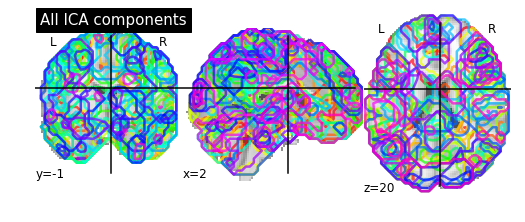

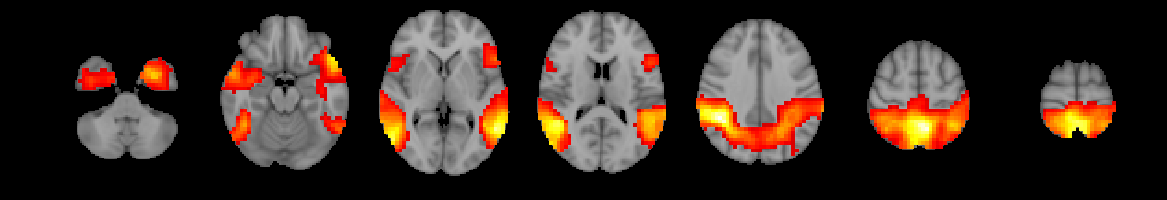

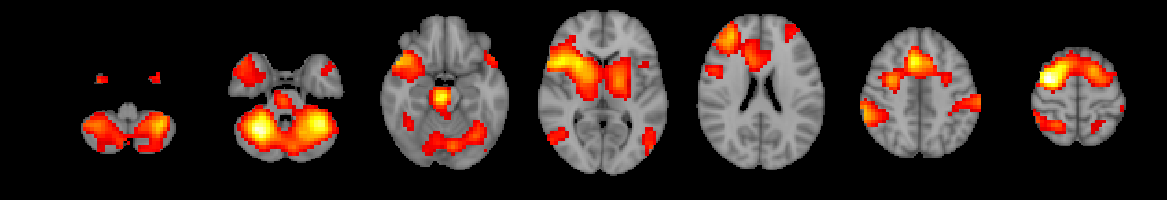

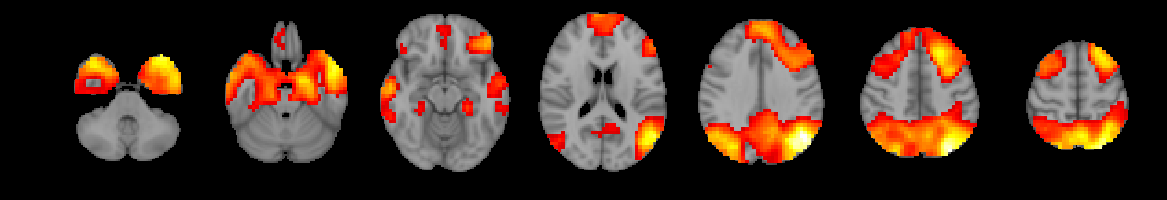

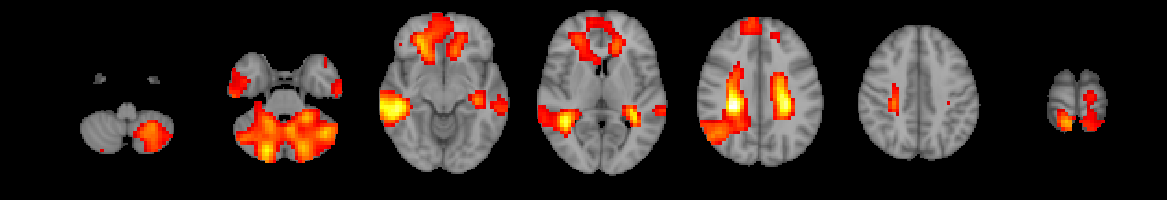

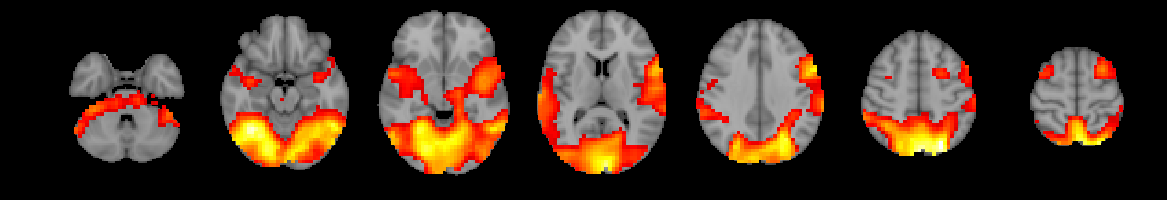

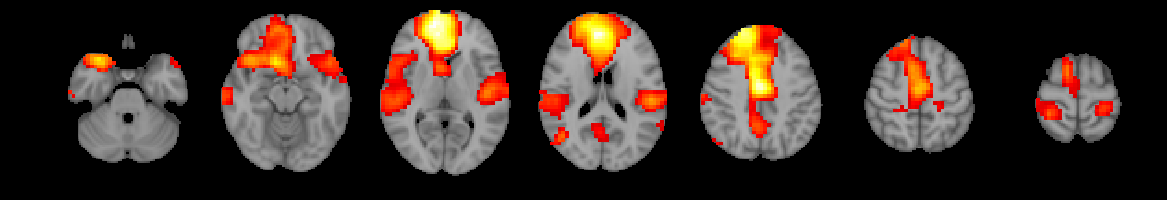

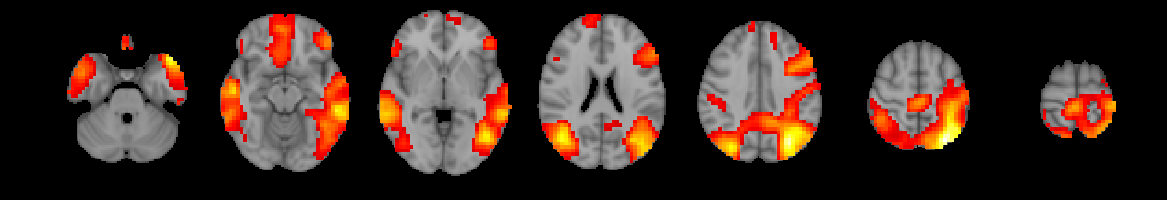

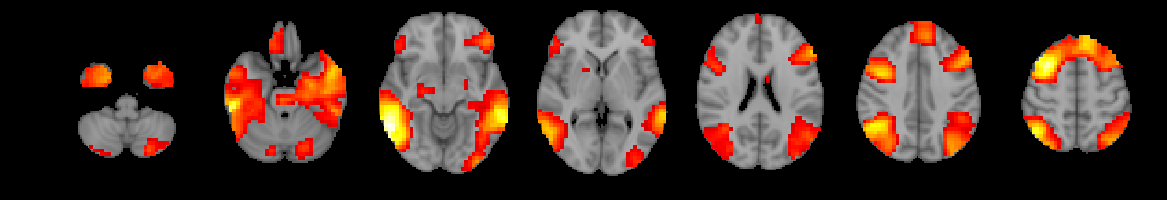

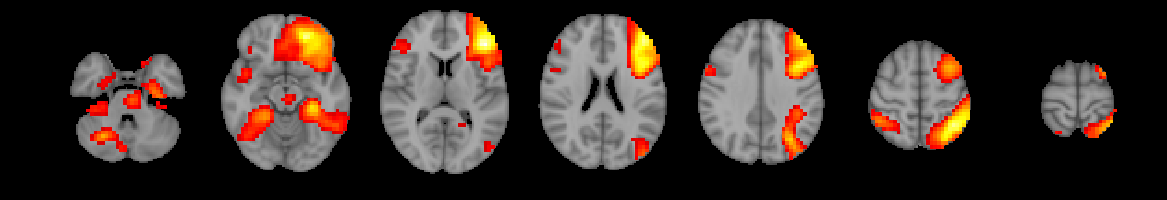

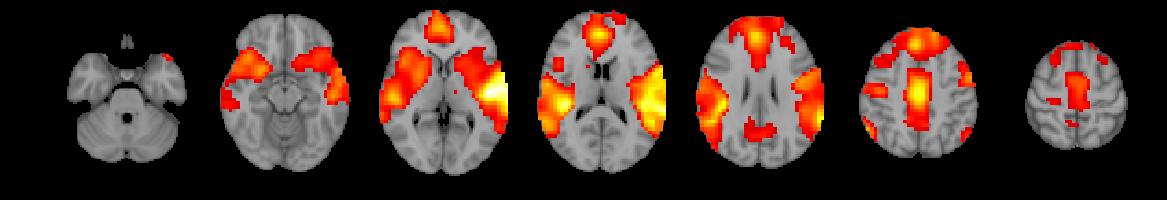

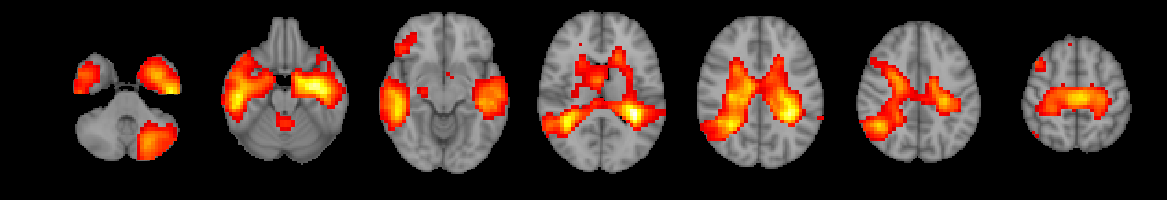

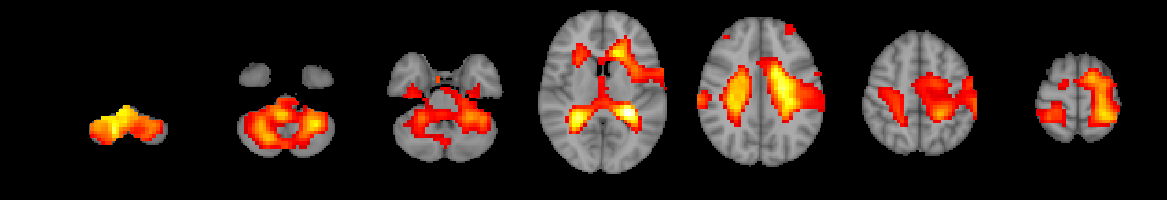

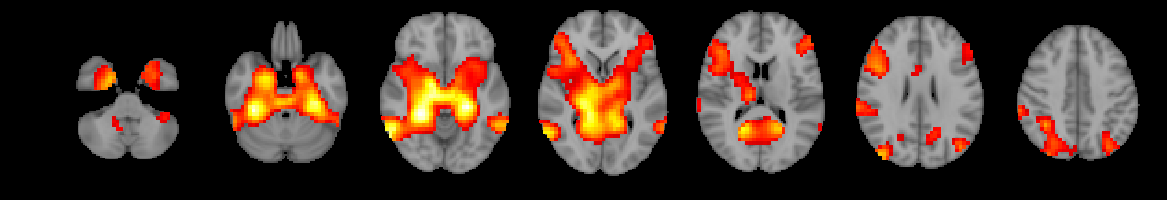

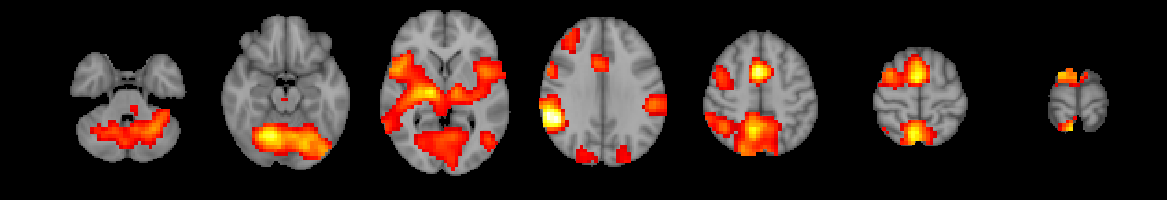

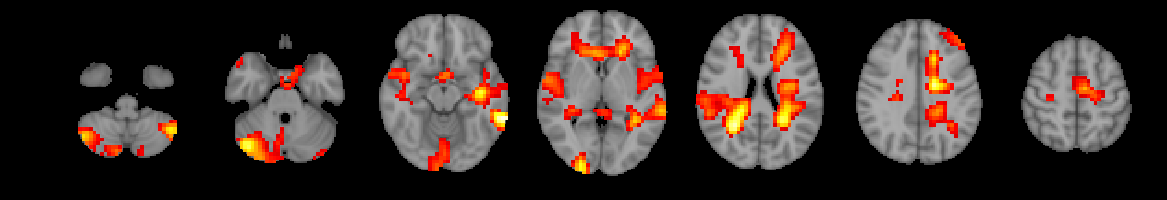

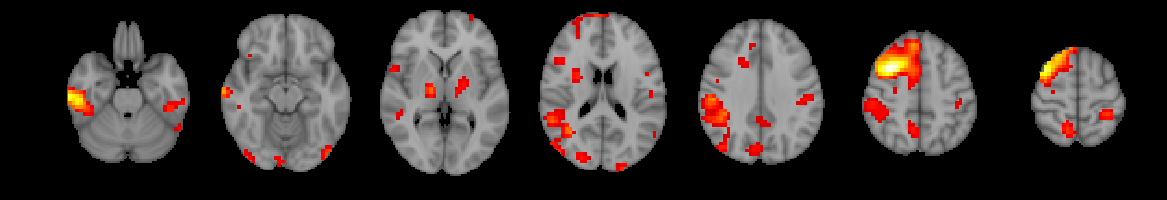

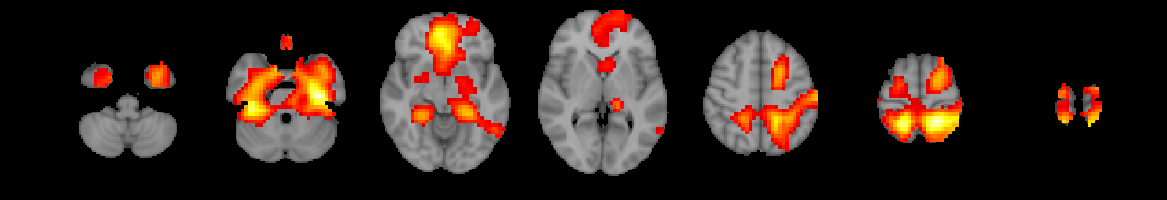

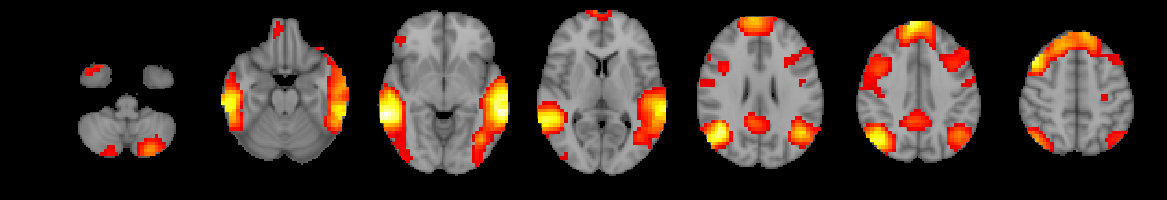

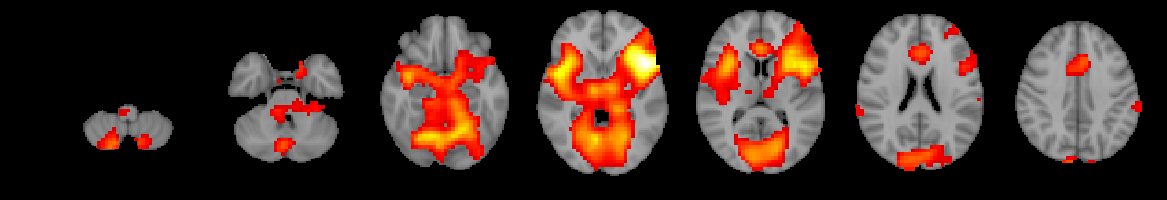

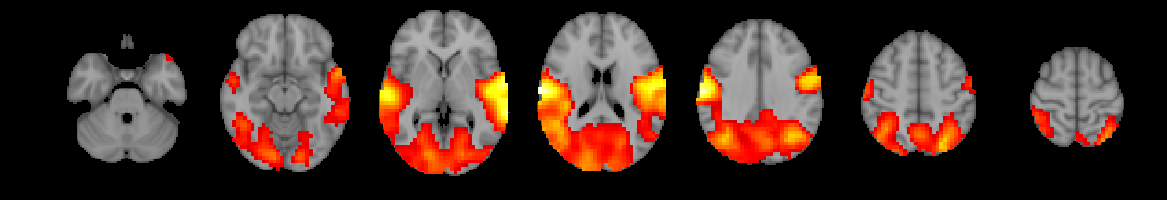

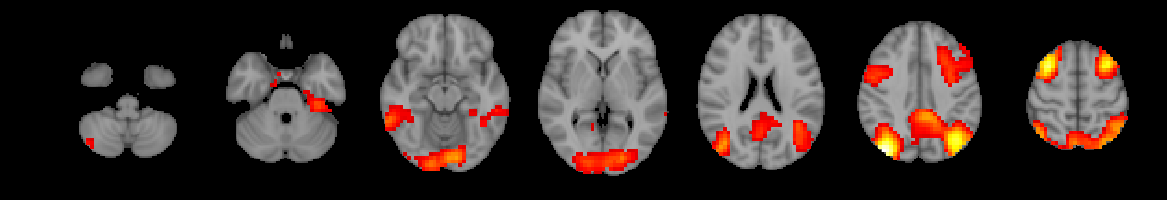

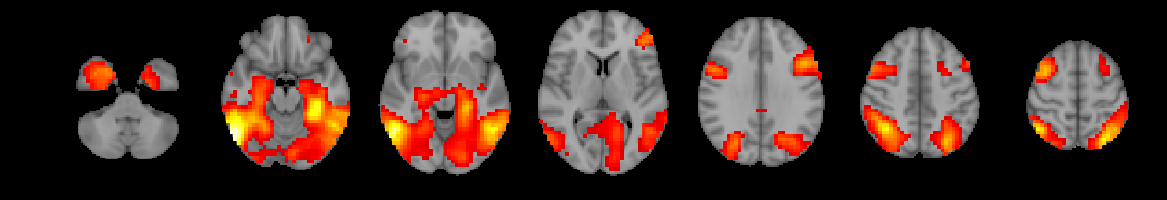

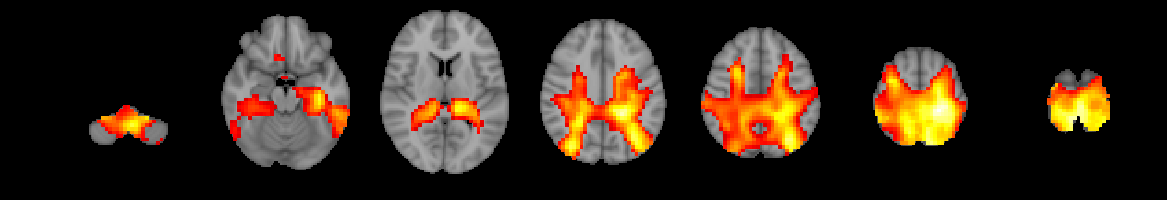

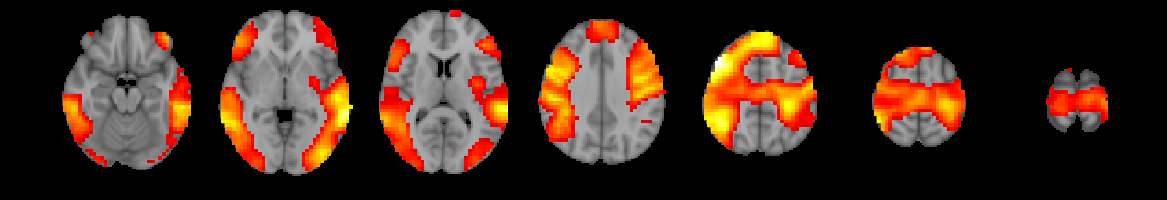

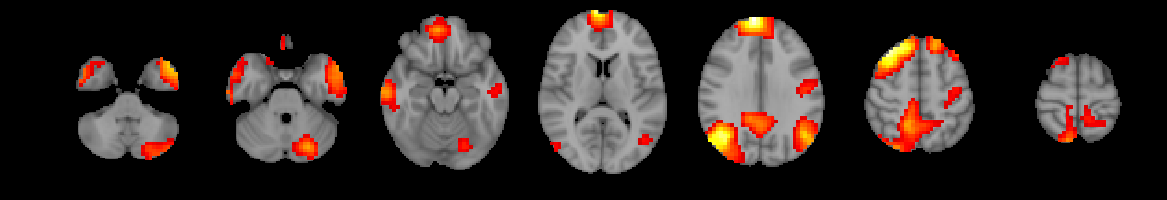

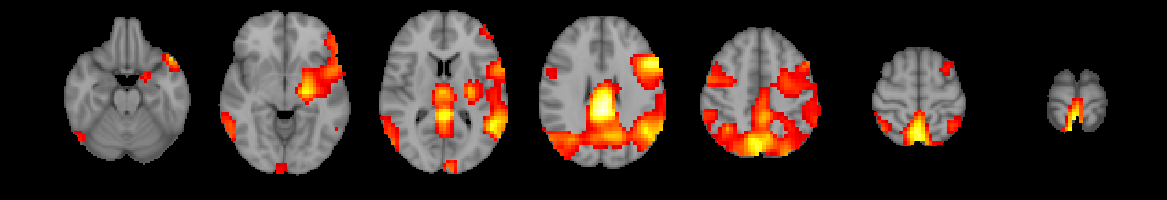

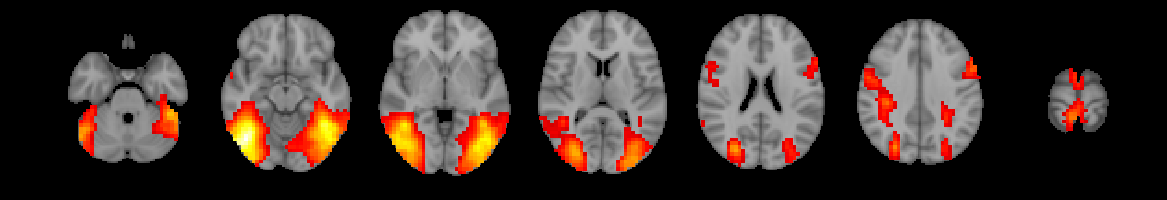

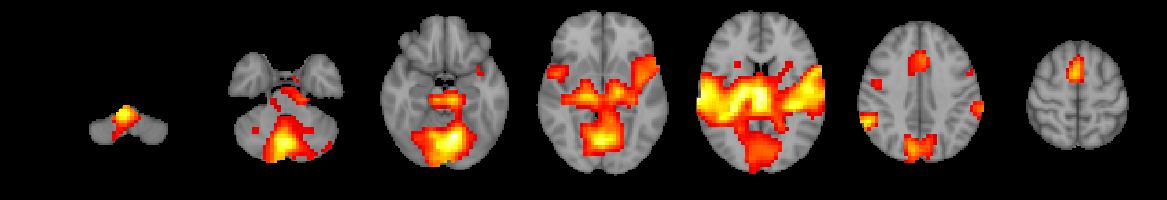

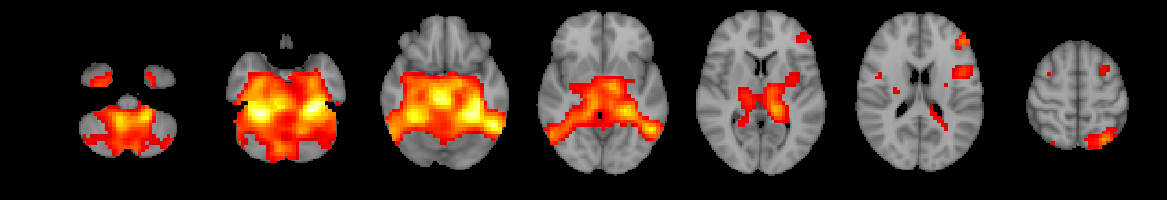

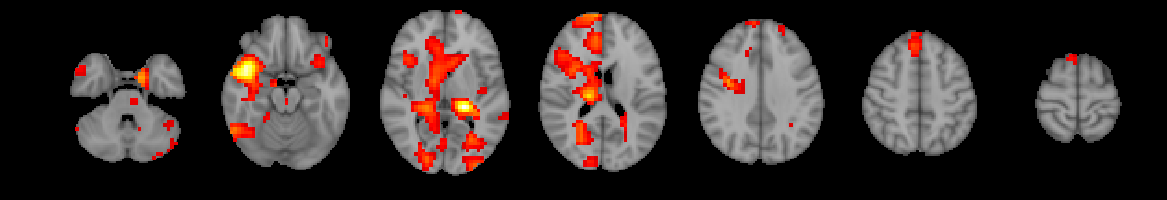

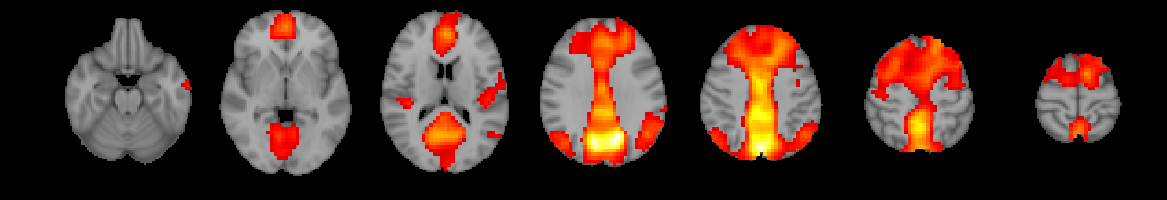

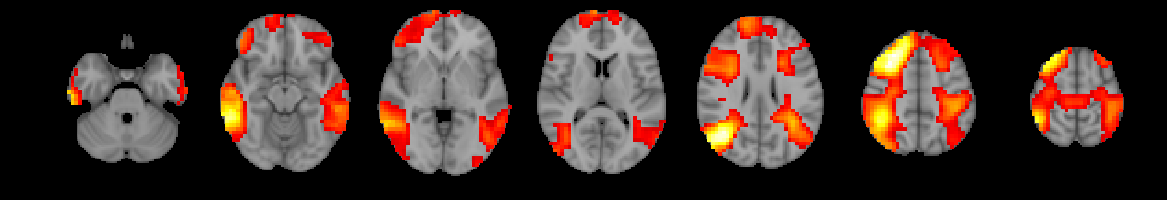

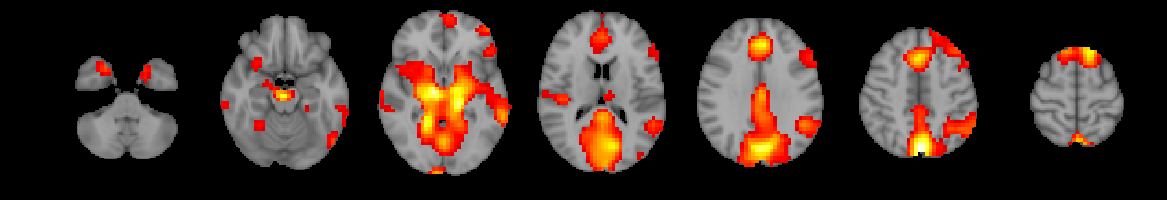

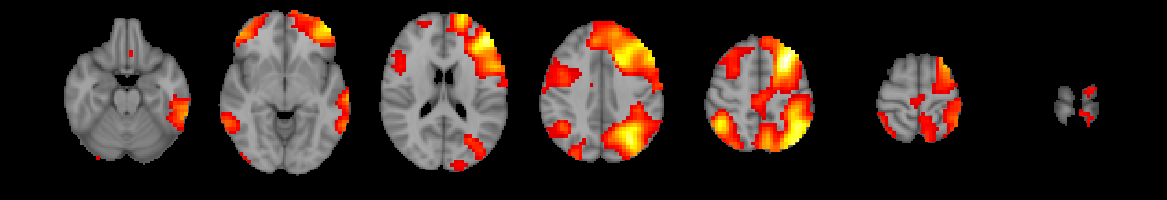

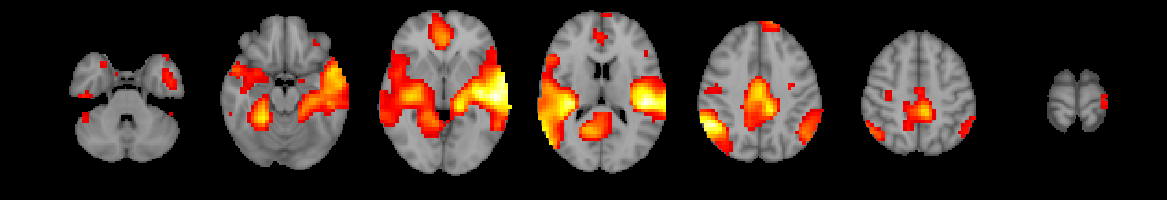

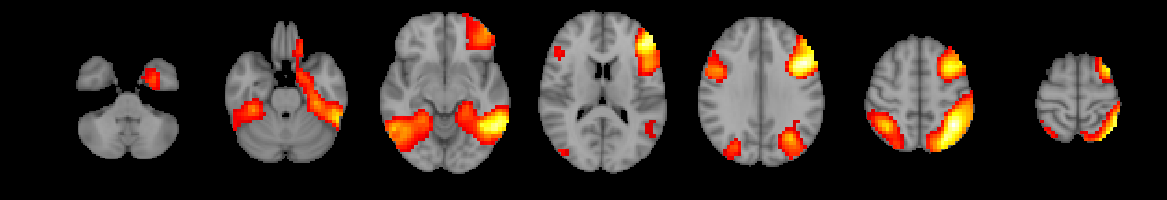

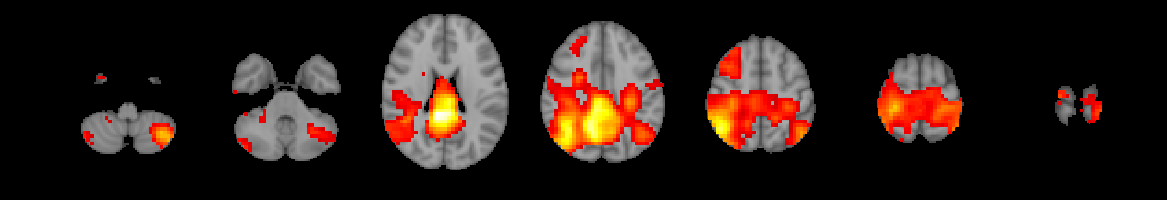

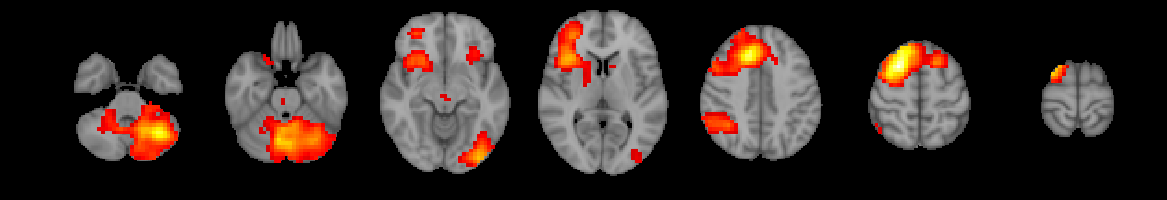

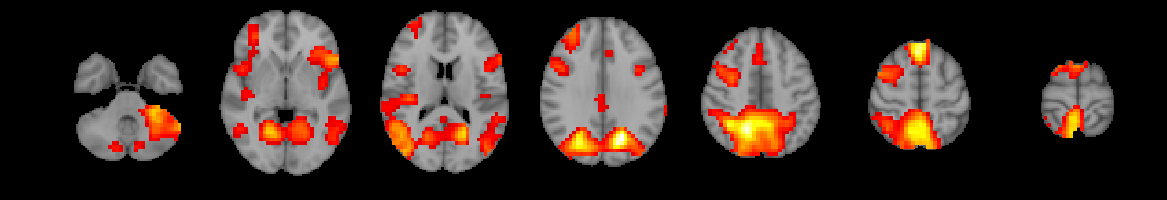

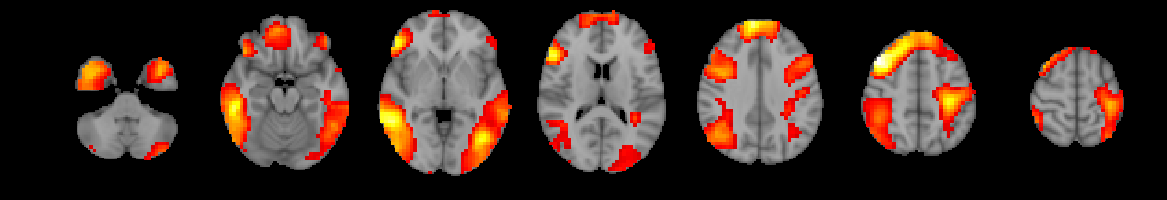

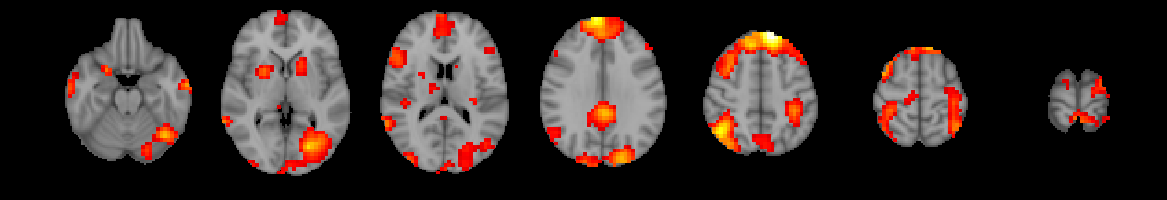

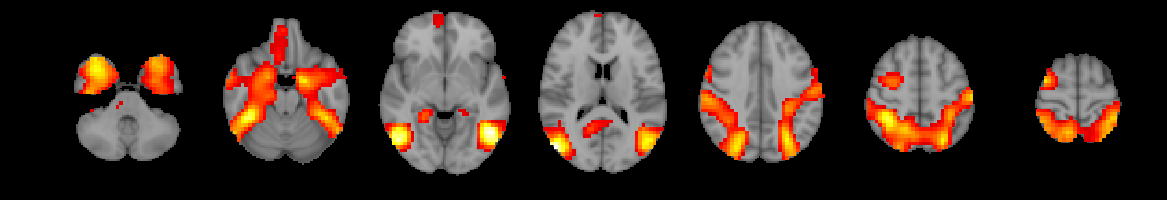

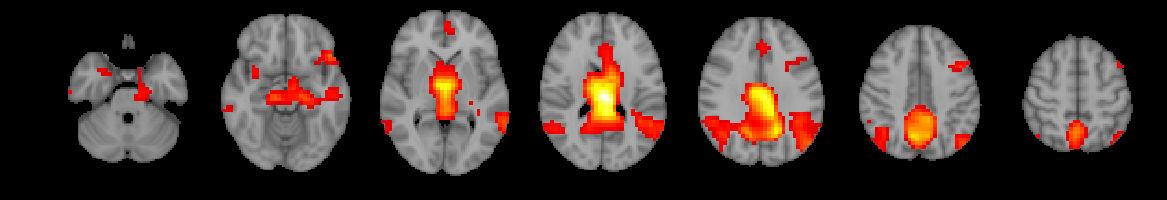

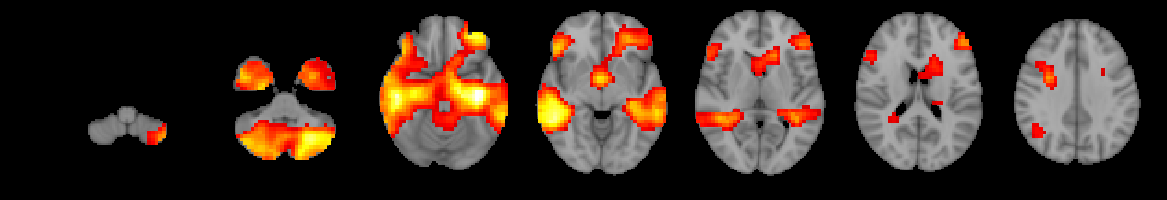

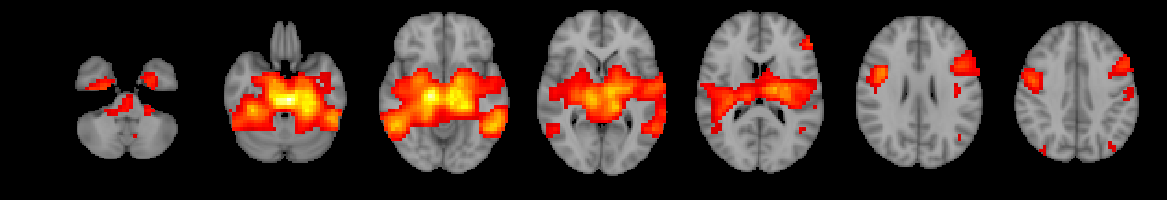

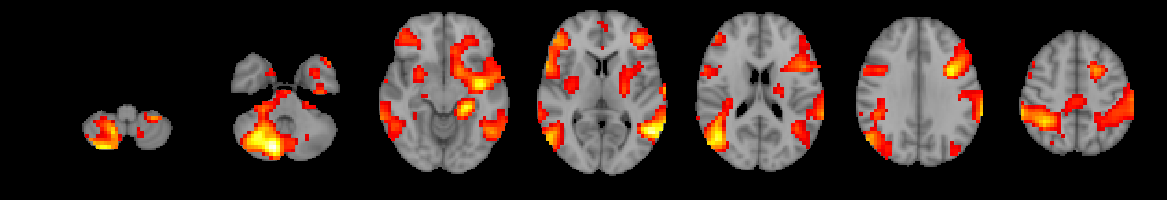

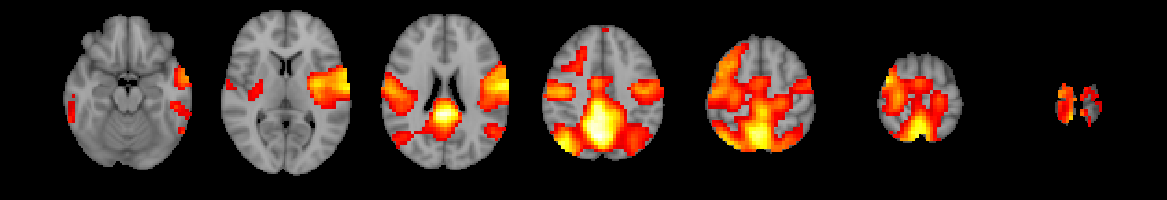

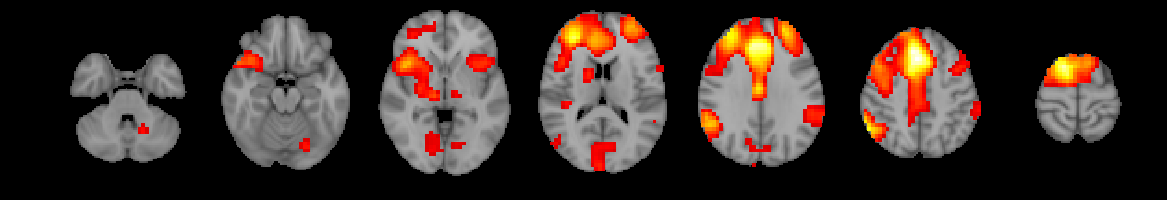

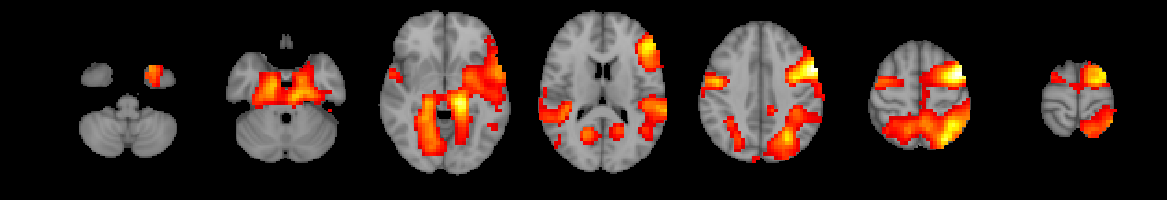

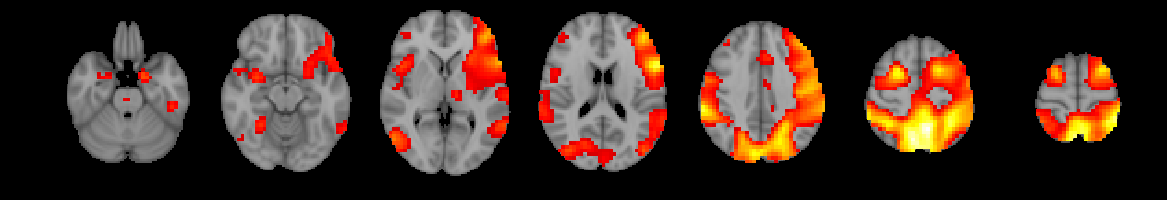

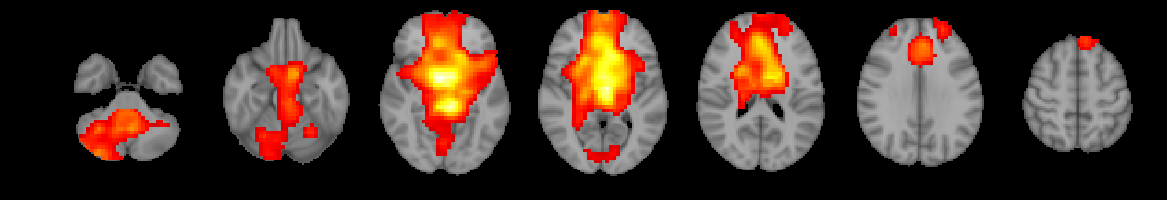

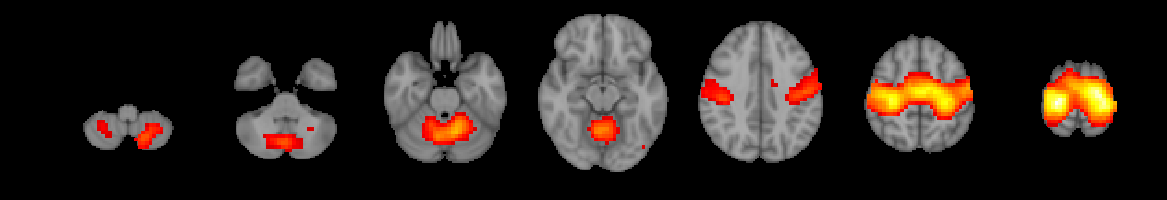

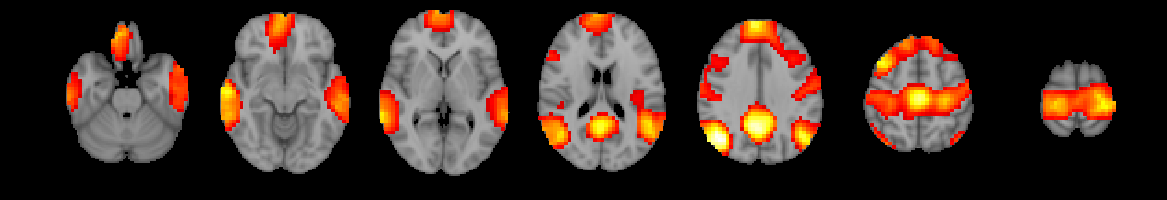

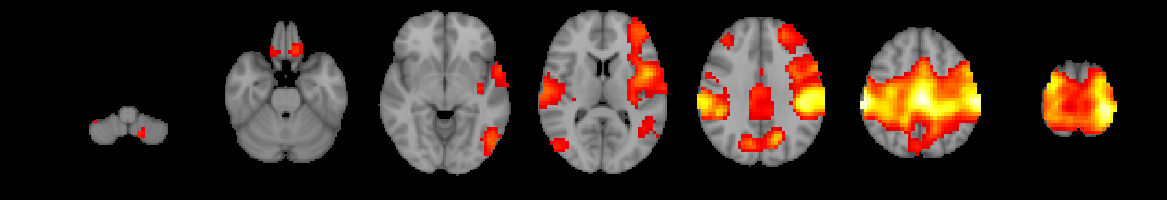

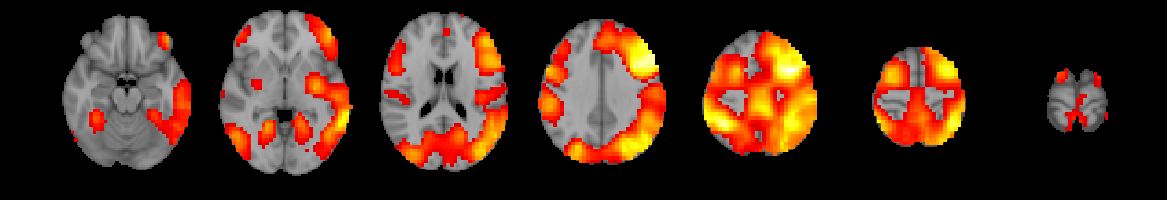

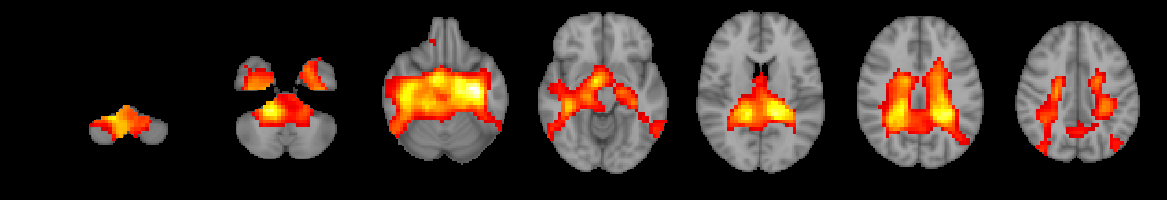

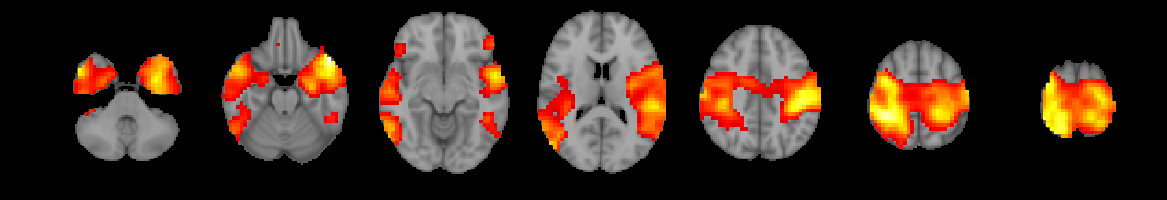

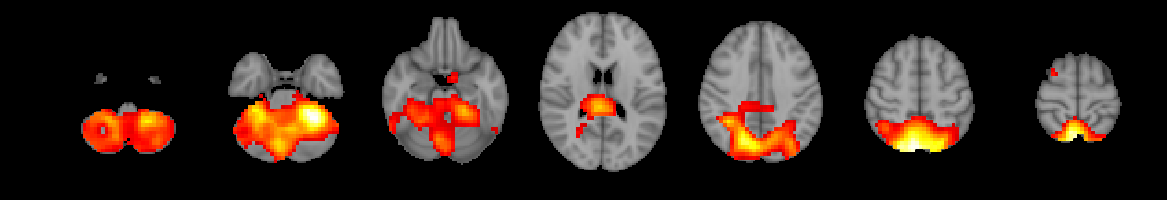

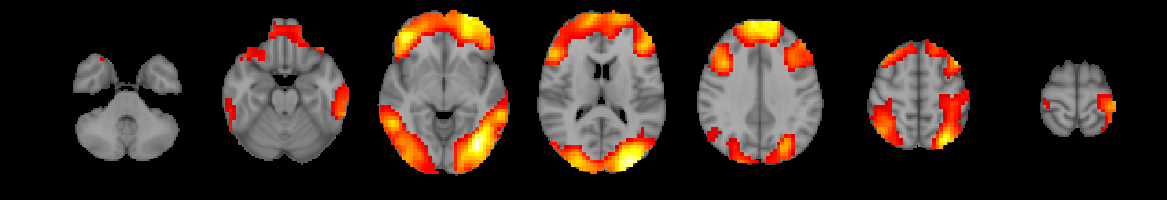

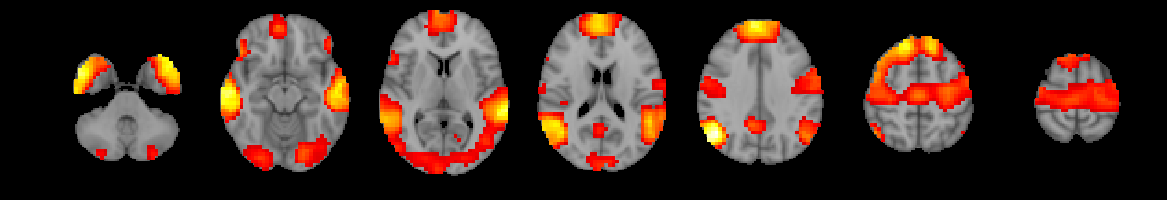

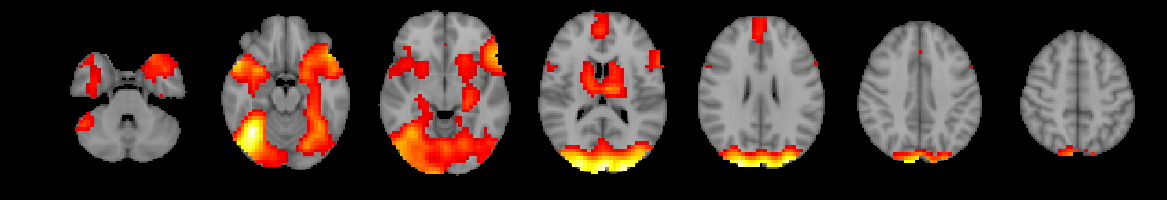

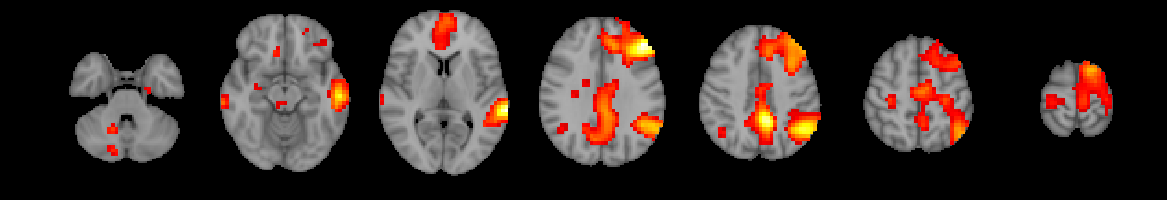

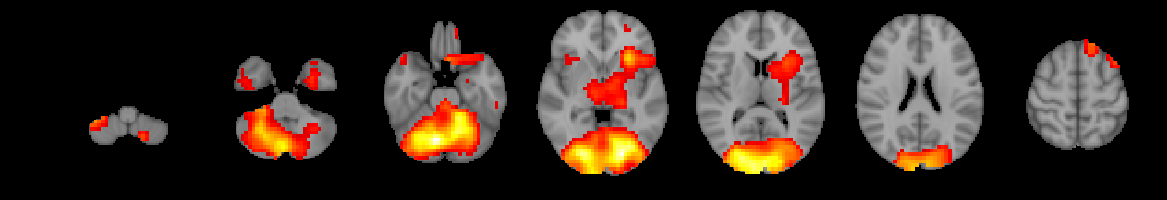

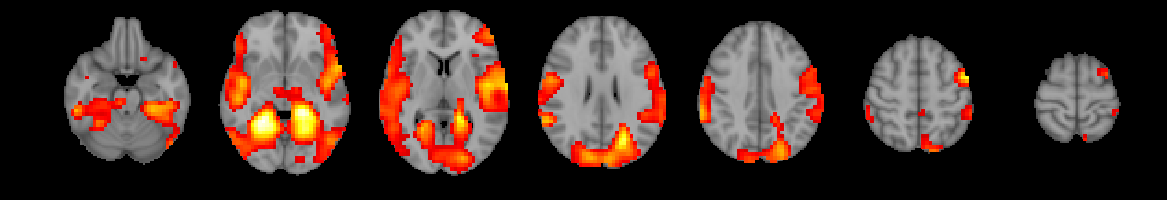

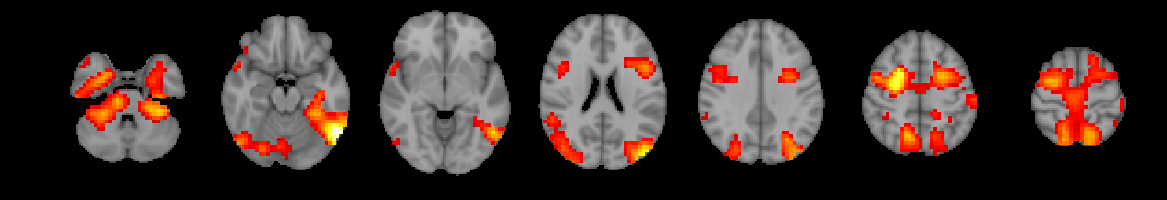

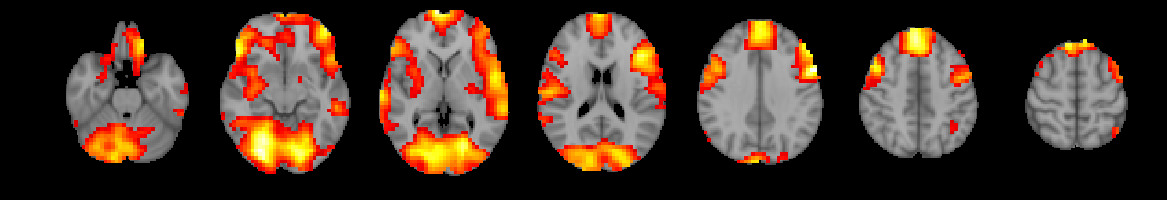

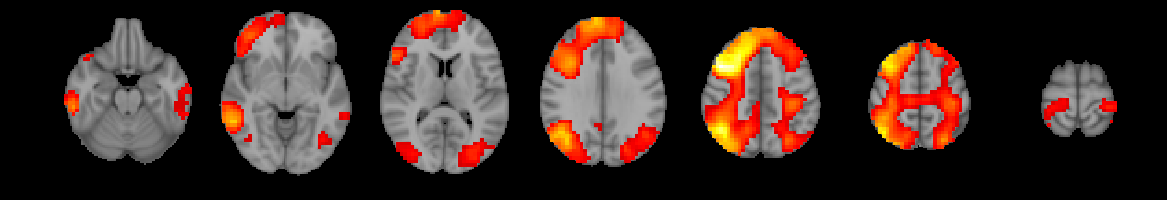

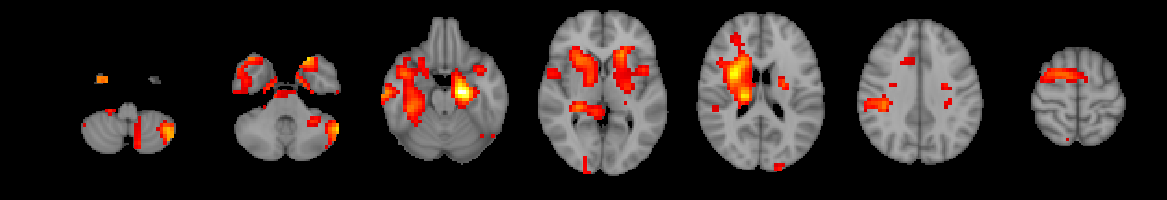

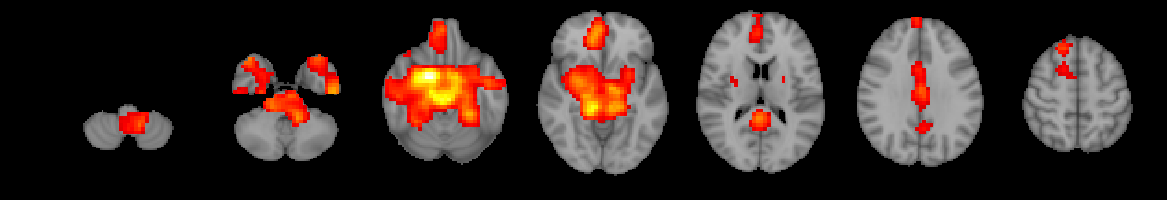

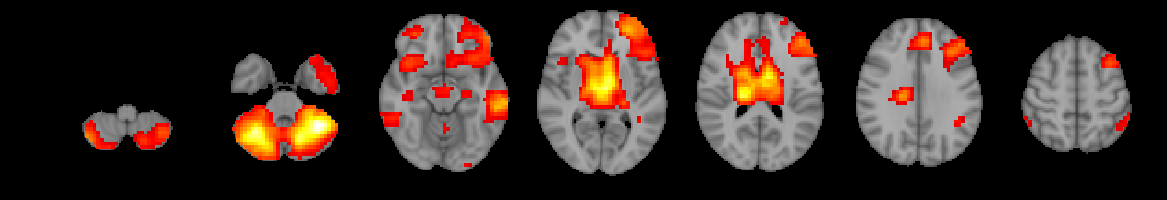

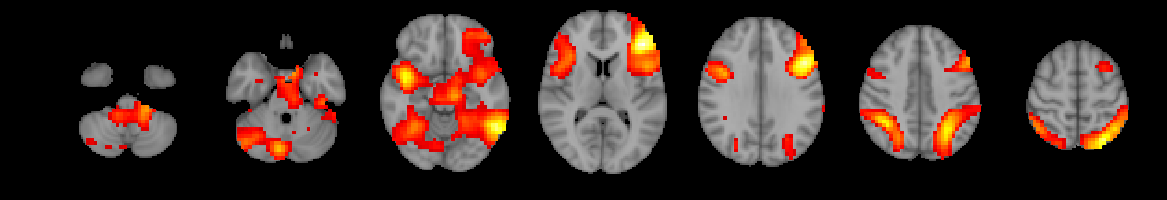

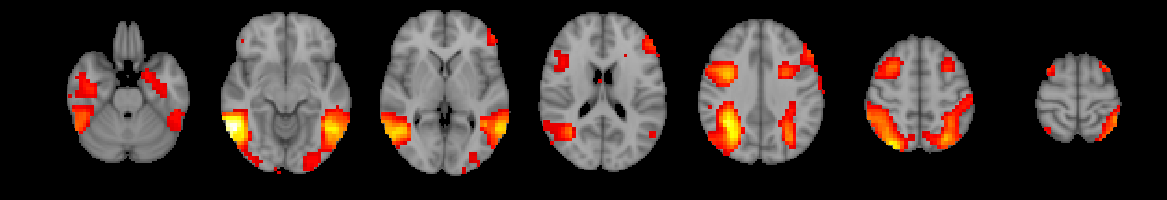

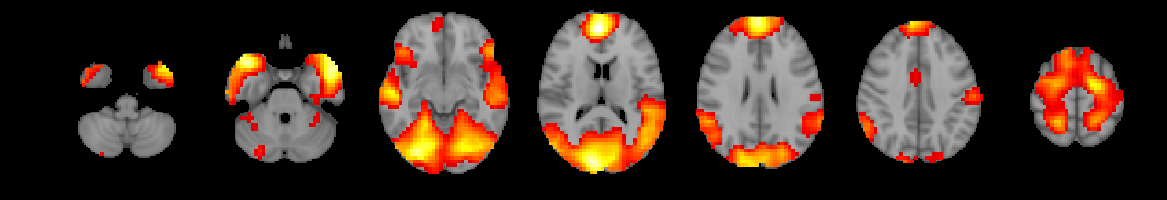

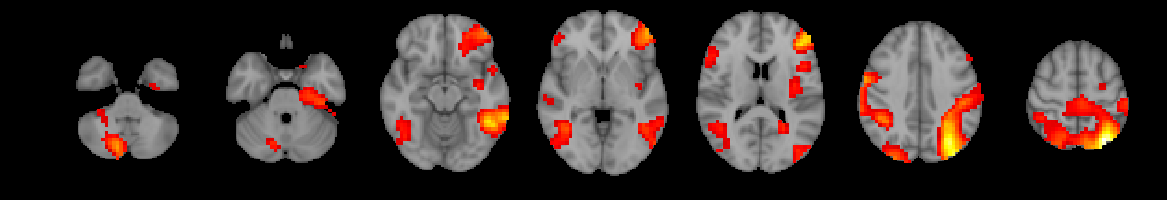

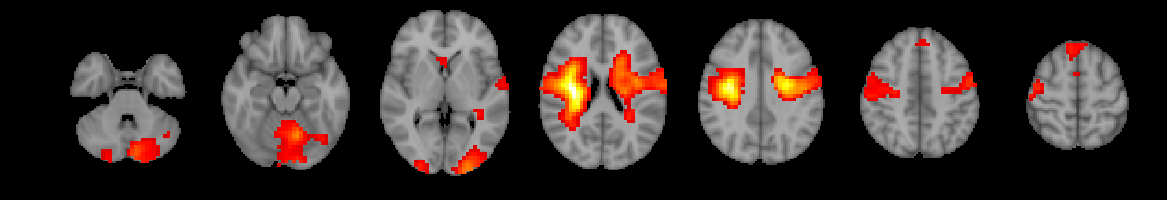

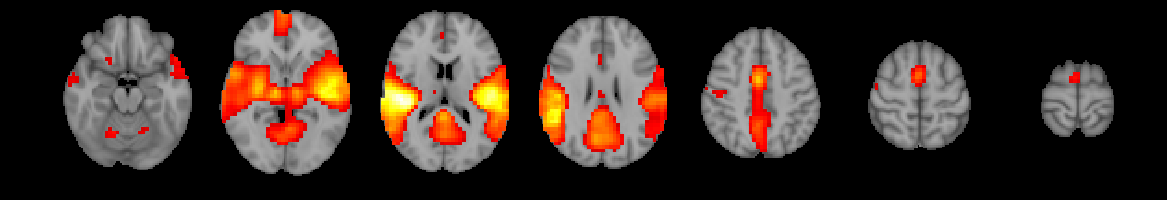

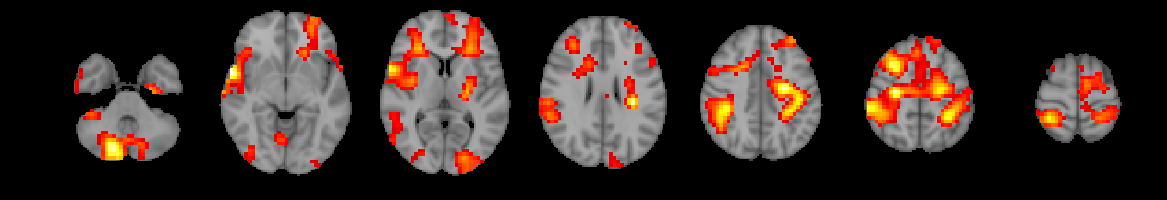

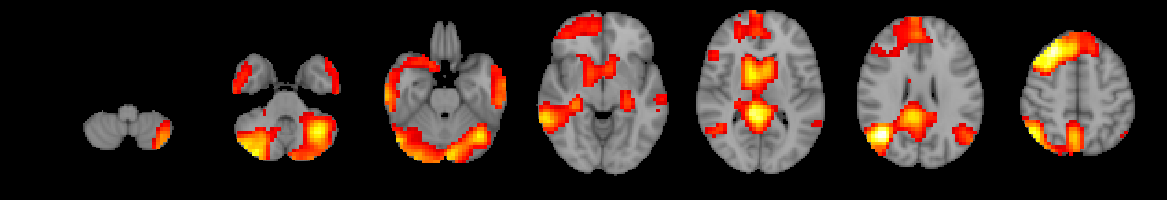

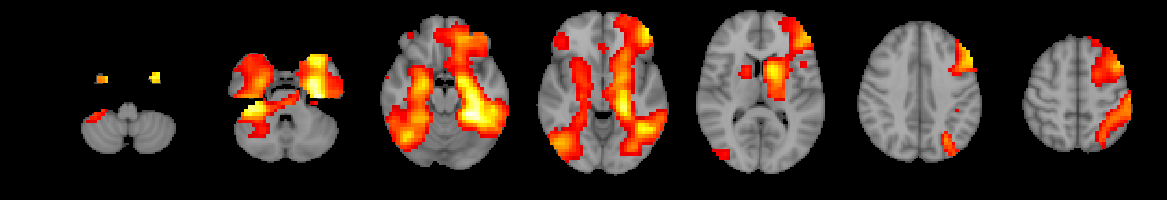

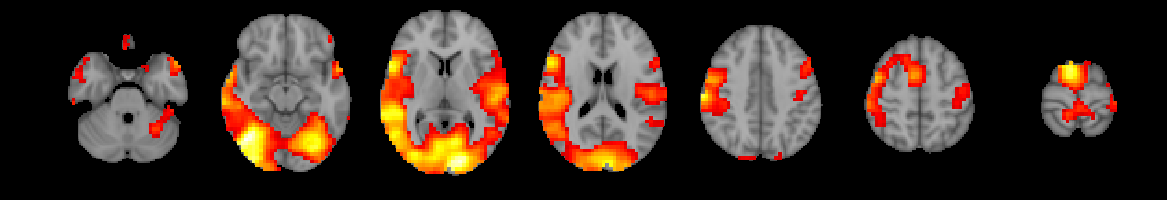

In [129]:
plot_net3(components  )